In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(11389, 1024) (11389,) float32
(2000, 1024) (2000,) float32


/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


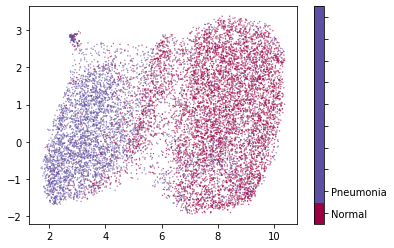

In [2]:
import umap


np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

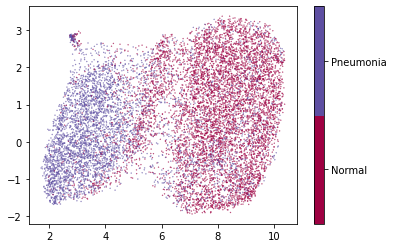

In [3]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(len(classes)+1)-0.5)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)

In [4]:
dist = euclidean_distances(X_train, squared = False)

print('\n')

    


In [5]:
print(dist[0:4, 0:4])
print( np.sum((X_train[1,:] - (X_train[6,:]+X_train[5,:]))**2))

[[ 0.       19.11934  14.659819 22.707005]
 [19.11934   0.       17.86558  15.537004]
 [14.659819 17.86558   0.       20.728548]
 [22.707005 15.537004 20.728548  0.      ]]
1124.894


In [6]:
n_neighbors=30

sort_idx = np.argsort(dist,axis=1)


sort_idx = sort_idx[:,1:n_neighbors+1]
print(sort_idx.shape, sort_idx[:,1].shape)


rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
rho = np.array(rho)

print(rho[0:4])
print(rho.shape, rho.dtype)

(11389, 30) (11389,)
[11.349591  10.8193655 10.711745  11.013099 ]
(11389,) float32


In [7]:
import gc

print(gc.collect())


32519


In [9]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs



In [10]:
sigmas = []

directed_graph = []
#'''
for i in range(n):
    if (i+1)%1000 == 0:
        print('Processed ', i+1, ' of ', n, ' samples.')
    sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)
    
    probs = np.zeros(n)
    probs[sort_idx[i,:]] = weights
    #print(sum(weights), np.log2(n_neighbors))
    #print(sort_idx[i,:])
    #print(probs[1770:1780])
    
    directed_graph.append(probs)

prob = np.array(directed_graph)
#'''  
    

dist = []
print(gc.collect())

Processed  1000  of  11389  samples.
Processed  2000  of  11389  samples.
Processed  3000  of  11389  samples.
Processed  4000  of  11389  samples.
Processed  5000  of  11389  samples.
Processed  6000  of  11389  samples.
Processed  7000  of  11389  samples.
Processed  8000  of  11389  samples.
Processed  9000  of  11389  samples.
Processed  10000  of  11389  samples.
Processed  11000  of  11389  samples.
0


In [11]:
import gc
gc.collect()



#'''
import numba 
from numba import prange
@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i]
            P[i,j] = p
            P[j,i] = p
            
    return P


P = symmetrization_step(prob)
#'''
print(np.sum(P[0,:]==0))

    

print(P.shape)

11335
(11389, 11389)


In [12]:
print(P[0,P[0,:]>0])
np.sum(P[0,P[0,:]>0])

[1.         0.85778284 0.05695006 0.03965829 0.01782204 0.09503651
 0.08652832 0.07921318 0.06625591 0.33568257 0.27015468 0.20447086
 0.08825967 0.10350372 0.9063398  0.04852736 0.04878853 0.09571587
 0.17552947 0.20657295 0.0462854  0.33148184 0.2547935  0.11234387
 0.03442172 0.23135702 1.         0.11346007 0.34688133 0.15954214
 0.05137551 0.06669252 0.22218749 1.         0.08861858 0.06772478
 0.07688212 0.03932606 0.04532325 0.29005596 0.05729729 0.05905012
 0.21788226 0.29870442 0.12648489 0.09950981 0.18757188 0.21862833
 0.06846666 0.5136881  0.15846702 0.19247647 0.2261818  0.12980774]


11.915762

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


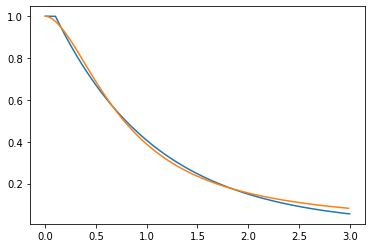

In [13]:
MIN_DIST = 0.1

x = np.linspace(0, 3, 300)
y = np.exp(- (x-MIN_DIST) * ( (x - MIN_DIST) >=0 ) )

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, y)

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x,y, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [14]:
import torch
from network_sig import network

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = network(channels=[X_train.shape[1],500,300,200,100,100,100,2]).to(device)

criterion_mse = torch.nn.MSELoss()

lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))


In [15]:
Y = []
X_train32 = X_train.astype(np.float32)

print('Conversion Done')
X_torch = torch.as_tensor(X_train32, dtype=torch.float32).to(device)
Y_umap = torch.as_tensor(y_umap, dtype=torch.float32).to(device)

X_torch_test = torch.as_tensor(X_test, dtype=torch.float32).to(device)
print('Tensor Build Done')


Conversion Done
Tensor Build Done


completed  0  of  11389
completed  10000  of  11389
(11389, 2)


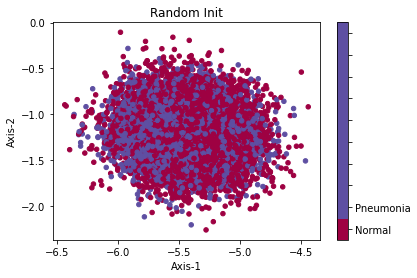

In [16]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y.shape)


plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 20)
plt.title("Random Init")
plt.xlabel("Axis-1") #, fontsize = 20); 
plt.ylabel("Axis-2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()

In [17]:
def criterion_pos_old(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2, dim = 0) ** b
    y = torch.log(factor)
    
    return y

def criterion_neg_old(x,y,a,b):
    factor = a * torch.sum((x-y)**2) ** b
    y = - torch.log(0.0001+factor) + torch.log(1 + factor)
    
    return y

def phi(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2+10**-15, dim=1) ** b
    y = 1/factor
    
    return y

def criterion_pos(x,y,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(prob)
    
    return torch.sum(y)

def criterion_neg(x,y,p,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(1-prob+0.000001)*(1-p)
    
    return torch.sum(y)
    

Y = model(X_torch[0:10,:])
Z = criterion_pos(Y[0:4,:],Y[4:8,:],1.0,1.0)
print(Y.size(), Z.size(), Z.item())

torch.Size([10, 2]) torch.Size([]) 1.3833913803100586


In [18]:
#from sklearn.manifold import SpectralEmbedding


#LEARNING_RATE = 1
epochs = 20

#xpp = xpp
#print(k)

batch_size = 60

CE_array = []
results = []
print("Running Gradient Descent: \n")
for epoch in range(epochs):
    
    for idx in range(int(n*10)):
        choices_0 = np.random.choice(n, batch_size)
        k_ch = np.random.randint(low = 0, high = n_neighbors, size=batch_size)
        choices_1 = sort_idx[choices_0,k_ch]
        
        #print(choices_0.shape,choices_1.shape)
        
        optimizer.zero_grad()
        
        loss = 0
        
        Y0 = model(X_torch[choices_0,:])
        Y1 = model(X_torch[choices_1,:])
        
        cr = criterion_mse(Y0,Y_umap[choices_0,:]) + criterion_mse(Y1, Y_umap[choices_1,:])
        loss = loss + cr
        #print(cr)
        if np.isnan(cr.detach().cpu().item()):
            print(epoch,idx,cr)
            break
        
        #gr_1 = get_grad_logphi(y[i,:], y[ij,:],a,b)
        #y[i,:] = y[i,:] + LEARNING_RATE * gr_1
        
        for j in range(5):
            k_ch = np.random.randint(low = 0, high = n, size=batch_size)
            #Y0 = model(X_torch[i:i+1,:])
            Y1 = model(X_torch[k_ch,:])
            Prob_sample = torch.as_tensor(P[choices_0,k_ch].reshape(-1), dtype=torch.float32).to(device)
            
            cr = criterion_mse(Y1, Y_umap[k_ch,:])
            loss = loss + cr
            #print('inside loop: ', cr)
            if np.isnan(cr.detach().cpu().item()):
                print('inside loop: ', epoch, idx, j, cr)
                break
            
            
        loss.backward()
        optimizer.step()
        
                
    #LEARNING_RATE = 1.0 - epoch / epochs
    if (epoch+1)%1 == 0:
        print('Completed ', epoch , ' of ', epochs)
        torch.save(model.state_dict(), 'nets_MSE_UMAP_pneumonia/epoch'+str(epoch)+'.pth')
        
        Y = []
        Y_test = []
        with torch.no_grad():
            for i in range(n):
                x_st = X_torch[i:i+1,:]
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y.append(y_st)
            

            
            for i in range(X_test.shape[0]):
                x_st = X_torch_test[i:i+1,:]
                #print(x_st.size())
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y_test.append(y_st)
        
        Y_test = np.array(Y_test)
        Y = np.array(Y)
        
        neigh.fit(Y, y_train) 
        y_nene_out = neigh.predict(Y_test)
        
        result = 1-np.mean(y_nene_out==y_test)
        
        results.append(result)
        
        d = {}
        d['Y'] = Y
        d['Y_test'] = Y_test
        savemat('nets_MSE_UMAP_pneumonia/test_data'+str(epoch)+'.mat', d)
        
        print('Error :', result)
        
    if (epoch+1)/5 == 0:
        lr = lr/10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


Running Gradient Descent: 

Completed  0  of  20
Error : 0.25049999999999994
Completed  1  of  20
Error : 0.23750000000000004
Completed  2  of  20
Error : 0.23399999999999999
Completed  3  of  20
Error : 0.247
Completed  4  of  20
Error : 0.24750000000000005
Completed  5  of  20
Error : 0.242
Completed  6  of  20
Error : 0.248
Completed  7  of  20
Error : 0.24750000000000005
Completed  8  of  20
Error : 0.24050000000000005
Completed  9  of  20
Error : 0.235
Completed  10  of  20
Error : 0.22999999999999998
Completed  11  of  20
Error : 0.24150000000000005
Completed  12  of  20
Error : 0.22550000000000003
Completed  13  of  20
Error : 0.22950000000000004
Completed  14  of  20
Error : 0.24050000000000005
Completed  15  of  20
Error : 0.239
Completed  16  of  20
Error : 0.23750000000000004
Completed  17  of  20
Error : 0.248
Completed  18  of  20
Error : 0.236
Completed  19  of  20
Error : 0.23299999999999998


completed  0  of  11389
completed  10000  of  11389
[[ 2.359499   -0.21042678]
 [ 5.1912518   0.93078625]
 [ 2.934543    0.03570655]
 ...
 [ 7.463166    1.5321807 ]
 [ 3.4883602   1.090833  ]
 [ 6.343736   -0.13850246]]


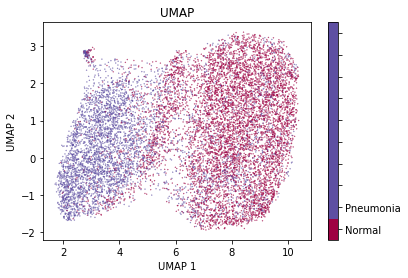

In [19]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y)

plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 0.1)
plt.title("UMAP")
plt.xlabel("UMAP 1") #, fontsize = 20); 
plt.ylabel("UMAP 2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()